In [1]:
from sea_breeze import load_model_data, utils
import xarray as xr
from dask.distributed import Client
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import hvplot.xarray
import numpy as np
import logging
from scipy.stats import spearmanr, pearsonr

logging.getLogger("flox").setLevel(logging.WARNING)

In [2]:
client = Client()

2025-07-11 15:41:44,508 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-latitude-321a20e399aeab2efe09bb6ac4d4f3ba' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: memory
old run_spec: DataNode(original-open_dataset-latitude-321a20e399aeab2efe09bb6ac4d4f3ba, type=<class 'xarray.core.indexing.ImplicitToExplicitIndexingAdapter'>, ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x14e18b6ed1c0>, key=BasicIndexer((slice(None, None, None),))))))
new run_spec: DataNode(original-open_dataset-latitude-321a20e399aeab2efe0

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44795,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:36751,Total threads: 2
Dashboard: /proxy/45833/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:46759,


In [4]:
aus2200 = xr.open_zarr("/g/data/ng72/ab4502/sea_breeze_detection/aus2200_smooth_s4/fuzzy_201301010000_201802282300.zarr/",chunks={}).chunk({"lat":50,"lon":50})
barra_c = xr.open_zarr("/g/data/ng72/ab4502/sea_breeze_detection/barra_c_smooth_s2/fuzzy_201301010000_201802282300.zarr/",chunks={}).chunk({"lat":50,"lon":50})
barra_r = xr.open_zarr("/g/data/ng72/ab4502/sea_breeze_detection/barra_r/fuzzy_201301010000_201802282300.zarr/",chunks={}).chunk({"lat":50,"lon":50})
era5 = xr.open_zarr("/g/data/ng72/ab4502/sea_breeze_detection/era5/fuzzy_201301010000_201802282300.zarr/",chunks={}).chunk({"lat":50,"lon":50})
obs = xr.open_zarr("/g/data/ng72/ab4502/sea_breeze_detection/stn_obs/fuzzy_201301010000_201802282300.zarr/")

In [5]:
def sel_obs_points(ds,obs):
    return ds.sel(lat=obs.lat,lon=obs.lon,method="nearest")

In [6]:
era5 = sel_obs_points(era5,obs).persist()

In [7]:
barra_r = sel_obs_points(barra_r,obs).persist()

In [8]:
barra_c = sel_obs_points(barra_c,obs).persist()

In [9]:
aus2200 = sel_obs_points(aus2200,obs).persist()

In [10]:
def slice_time_to_aus2200(ds,aus2200):
    return ds.sel(time=aus2200.time)

era5 = slice_time_to_aus2200(era5,aus2200)
barra_r = slice_time_to_aus2200(barra_r,aus2200)
barra_c = slice_time_to_aus2200(barra_c,aus2200)
obs = slice_time_to_aus2200(obs,aus2200)

In [11]:
def replace_nans(ds,obs):
    return xr.where(obs.__xarray_dataarray_variable__.isnull(), np.nan, ds)

era5 = replace_nans(era5,obs)
barra_r = replace_nans(barra_r,obs)
barra_c = replace_nans(barra_c,obs)
aus2200 = replace_nans(aus2200,obs)

In [12]:
def get_daily_counts(ds,thresh):
    return (ds.groupby("time.date").max() >= thresh).sum("date")

obs_daily_count = get_daily_counts(obs, obs.__xarray_dataarray_variable__.quantile(0.995).values)
era5_daily_count = get_daily_counts(era5, era5.chunk({"time":-1}).__xarray_dataarray_variable__.quantile(0.995).values)
barra_r_daily_count = get_daily_counts(barra_r, barra_r.chunk({"time":-1}).__xarray_dataarray_variable__.quantile(0.995).values)
barra_c_daily_count = get_daily_counts(barra_c, barra_c.chunk({"time":-1}).__xarray_dataarray_variable__.quantile(0.995).values)
aus2200_daily_count = get_daily_counts(aus2200, aus2200.chunk({"time":-1}).__xarray_dataarray_variable__.quantile(0.995).values)

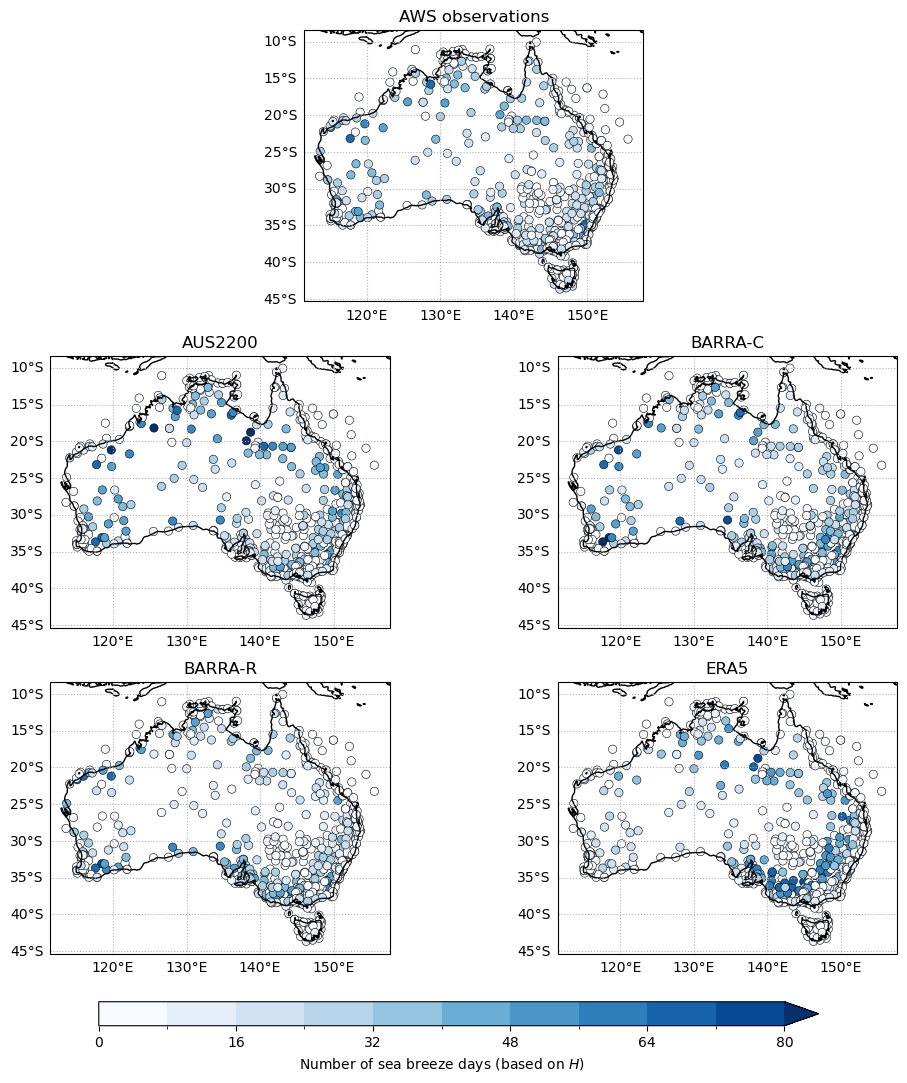

In [21]:
shape = (3,2)

plt.figure(figsize=[12,12])
ax=plt.subplot2grid(shape, (0,0), colspan=2, projection=ccrs.PlateCarree())
obs_daily_count.plot.scatter(
   x="longitude",y="latitude",hue="__xarray_dataarray_variable__",ax=ax,levels=np.linspace(0,80,11),cmap="Blues",edgecolor="k",lw=0.4,add_colorbar=False)
ax.coastlines()
ax.gridlines(ls=":",draw_labels=["left","bottom"])
plt.title("AWS observations")

ax=plt.subplot2grid(shape, (1,0), colspan=1, projection=ccrs.PlateCarree())
aus2200_daily_count.plot.scatter(
    x="longitude",y="latitude",hue="__xarray_dataarray_variable__",ax=ax,levels=np.linspace(0,80,11),cmap="Blues",edgecolor="k",lw=0.4,add_colorbar=False)
ax.coastlines()
ax.gridlines(ls=":",draw_labels=["left","bottom"])
plt.title("AUS2200")

ax=plt.subplot2grid(shape, (1,1), colspan=1, projection=ccrs.PlateCarree())
barra_c_daily_count.plot.scatter(
    x="longitude",y="latitude",hue="__xarray_dataarray_variable__",ax=ax,levels=np.linspace(0,80,11),cmap="Blues",edgecolor="k",lw=0.4,add_colorbar=False)
ax.coastlines()
ax.gridlines(ls=":",draw_labels=["left","bottom"])
plt.title("BARRA-C")

ax=plt.subplot2grid(shape, (2,0), colspan=1, projection=ccrs.PlateCarree())
barra_r_daily_count.plot.scatter(
    x="longitude",y="latitude",hue="__xarray_dataarray_variable__",ax=ax,levels=np.linspace(0,80,11),cmap="Blues",edgecolor="k",lw=0.4,add_colorbar=False)
ax.coastlines()
ax.gridlines(ls=":",draw_labels=["left","bottom"])
plt.title("BARRA-R")

ax=plt.subplot2grid(shape, (2,1), colspan=1, projection=ccrs.PlateCarree())
c = era5_daily_count.plot.scatter(
    x="longitude",y="latitude",hue="__xarray_dataarray_variable__",ax=ax,levels=np.linspace(0,80,11),cmap="Blues",edgecolor="k",lw=0.4,add_colorbar=False)
ax.coastlines()
ax.gridlines(ls=":",draw_labels=["left","bottom"])
plt.title("ERA5")

cb=plt.colorbar(c,plt.axes([0.2,0.05,0.6,0.02]),orientation="horizontal")
cb.set_label("Number of sea breeze days (based on $H$)")

plt.savefig("/g/data/ng72/ab4502/figs/methods_paper/eval1.jpeg",bbox_inches="tight",dpi=500)

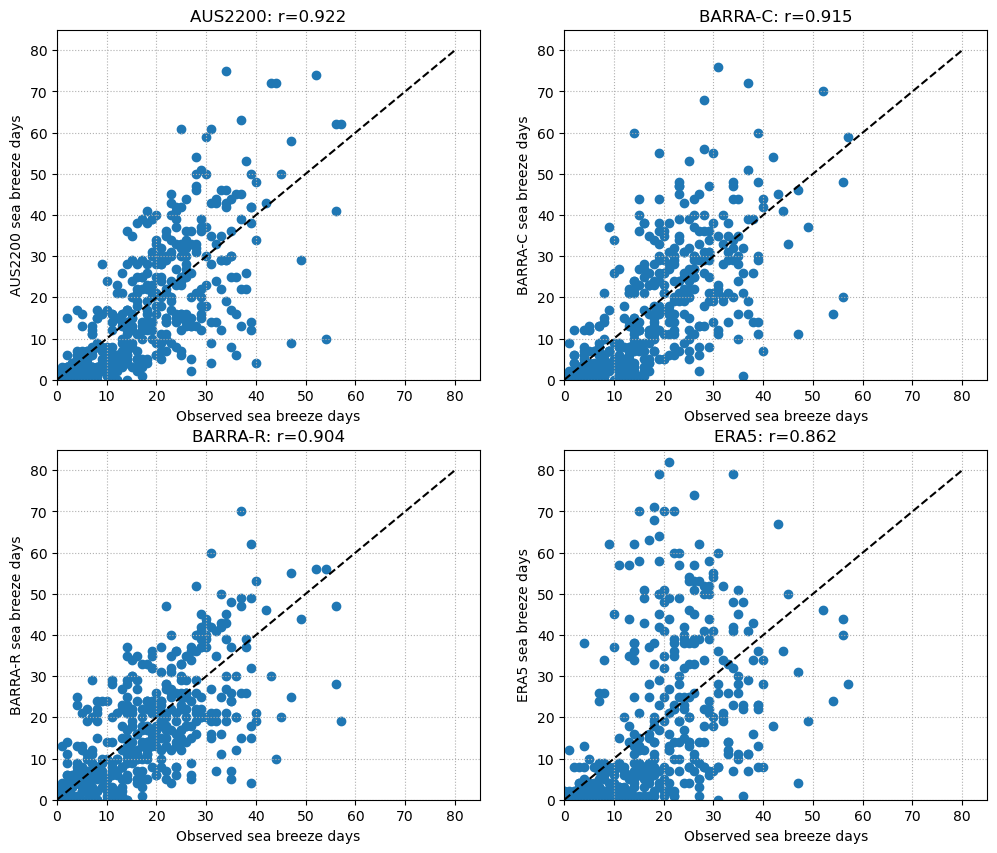

In [22]:
plt.figure(figsize=[12,10])

plt.subplot(2,2,1)
plt.scatter(obs_daily_count.__xarray_dataarray_variable__,
           aus2200_daily_count.__xarray_dataarray_variable__)
plt.gca().grid(ls=":")
plt.ylim([0,85])
plt.xlim([0,85])
plt.plot([0,80],[0,80],ls="--",color="k")
plt.xlabel("Observed sea breeze days")
plt.ylabel("AUS2200 sea breeze days")
plt.title("AUS2200: r="+str(np.round(spearmanr(obs_daily_count.__xarray_dataarray_variable__,aus2200_daily_count.__xarray_dataarray_variable__).statistic,3)))

plt.subplot(2,2,2)
plt.scatter(obs_daily_count.__xarray_dataarray_variable__,
           barra_c_daily_count.__xarray_dataarray_variable__)
plt.gca().grid(ls=":")
plt.ylim([0,85])
plt.xlim([0,85])
plt.plot([0,80],[0,80],ls="--",color="k")
plt.xlabel("Observed sea breeze days")
plt.ylabel("BARRA-C sea breeze days")
plt.title("BARRA-C: r="+str(np.round(spearmanr(obs_daily_count.__xarray_dataarray_variable__,barra_c_daily_count.__xarray_dataarray_variable__).statistic,3)))

plt.subplot(2,2,3)
plt.scatter(obs_daily_count.__xarray_dataarray_variable__,
           barra_r_daily_count.__xarray_dataarray_variable__)
plt.gca().grid(ls=":")
plt.ylim([0,85])
plt.xlim([0,85])
plt.plot([0,80],[0,80],ls="--",color="k")
plt.xlabel("Observed sea breeze days")
plt.ylabel("BARRA-R sea breeze days")
plt.title("BARRA-R: r="+str(np.round(spearmanr(obs_daily_count.__xarray_dataarray_variable__,barra_r_daily_count.__xarray_dataarray_variable__).statistic,3)))

plt.subplot(2,2,4)
plt.scatter(obs_daily_count.__xarray_dataarray_variable__,
           era5_daily_count.__xarray_dataarray_variable__)
plt.gca().grid(ls=":")
plt.ylim([0,85])
plt.xlim([0,85])
plt.plot([0,80],[0,80],ls="--",color="k")
plt.xlabel("Observed sea breeze days")
plt.ylabel("ERA5 sea breeze days")
plt.title("ERA5: r="+str(np.round(spearmanr(obs_daily_count.__xarray_dataarray_variable__,era5_daily_count.__xarray_dataarray_variable__).statistic,3)))

plt.savefig("/g/data/ng72/ab4502/figs/methods_paper/eval2.jpeg",bbox_inches="tight",dpi=500)

In [15]:

def get_hourly_counts(ds,thresh):
    return (ds >= thresh).groupby("time.hour").sum().mean("station")


obs_hourly_count = get_hourly_counts(obs, obs.__xarray_dataarray_variable__.quantile(0.995).values)
era5_hourly_count = get_hourly_counts(era5, era5.chunk({"time":-1}).__xarray_dataarray_variable__.quantile(0.995).values)
barra_r_hourly_count = get_hourly_counts(barra_r, barra_r.chunk({"time":-1}).__xarray_dataarray_variable__.quantile(0.995).values)
barra_c_hourly_count = get_hourly_counts(barra_c, barra_c.chunk({"time":-1}).__xarray_dataarray_variable__.quantile(0.995).values)
aus2200_hourly_count = get_hourly_counts(aus2200, aus2200.chunk({"time":-1}).__xarray_dataarray_variable__.quantile(0.995).values)

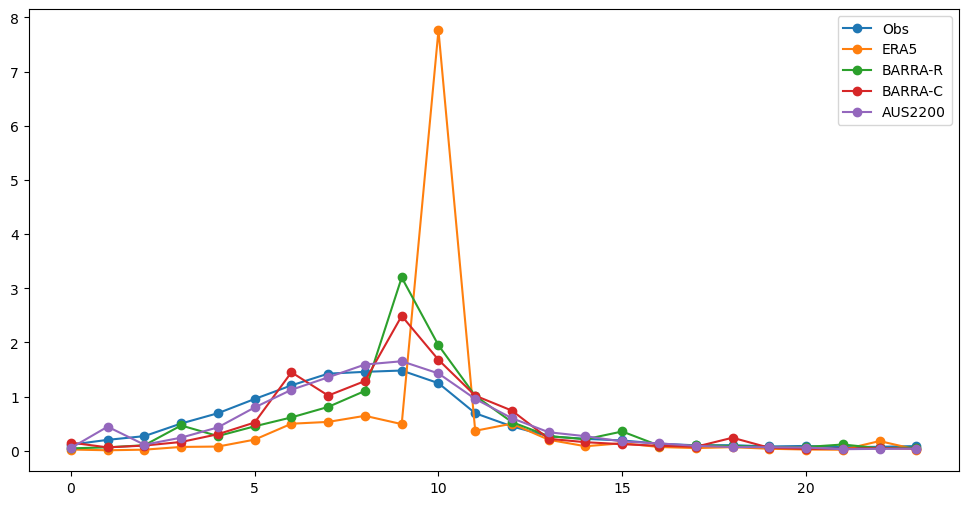

In [16]:
plt.figure(figsize=[12,6])
plt.plot(obs_hourly_count.__xarray_dataarray_variable__,marker="o",label="Obs")
plt.plot(era5_hourly_count.__xarray_dataarray_variable__,marker="o",label="ERA5")
plt.plot(barra_r_hourly_count.__xarray_dataarray_variable__,marker="o",label="BARRA-R")
plt.plot(barra_c_hourly_count.__xarray_dataarray_variable__,marker="o",label="BARRA-C")
plt.plot(aus2200_hourly_count.__xarray_dataarray_variable__,marker="o",label="AUS2200")
plt.legend()

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/flox/core.py:1247: RuntimeWarning: All-NaN slice encountered
  result = combine(array, axis=axis_, keepdims=True)


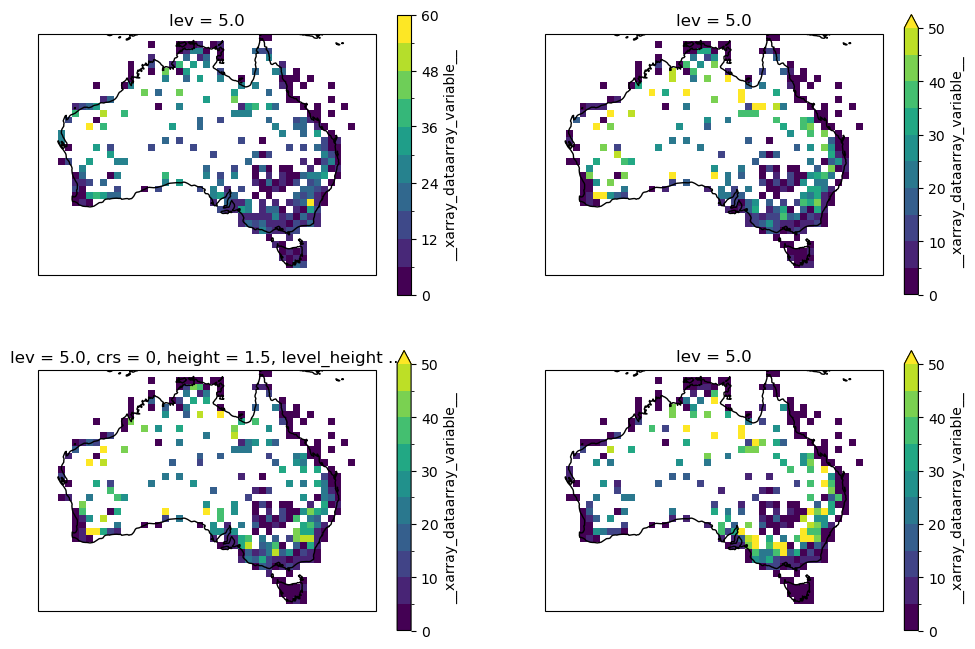

In [118]:
plt.figure(figsize=[12,8])

ax=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
obs_daily_count.groupby(
    lon=xr.groupers.BinGrouper(bins=np.arange(110,160,1)),
    lat=xr.groupers.BinGrouper(bins=np.arange(-45,-9,1))
).mean().__xarray_dataarray_variable__.plot(x="lon_bins",y="lat_bins",vmin=0,vmax=60,levels=11)
ax.coastlines()

ax=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
aus2200_daily_count.groupby(
    lon=xr.groupers.BinGrouper(bins=np.arange(110,160,1)),
    lat=xr.groupers.BinGrouper(bins=np.arange(-45,-9,1))
).mean().__xarray_dataarray_variable__.plot(x="lon_bins",y="lat_bins",vmin=0,vmax=50,levels=11)
ax.coastlines()


ax=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
barra_c_daily_count.groupby(
    longitude=xr.groupers.BinGrouper(bins=np.arange(110,160,1)),
    latitude=xr.groupers.BinGrouper(bins=np.arange(-45,-9,1))
).mean().__xarray_dataarray_variable__.plot(x="longitude_bins",y="latitude_bins",vmin=0,vmax=50,levels=11)
ax.coastlines()


ax=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
era5_daily_count.groupby(
    longitude=xr.groupers.BinGrouper(bins=np.arange(110,160,1)),
    latitude=xr.groupers.BinGrouper(bins=np.arange(-45,-9,1))
).mean().__xarray_dataarray_variable__.plot(x="longitude_bins",y="latitude_bins",vmin=0,vmax=50,levels=11)
ax.coastlines()

Text(0.5, 1.0, '')

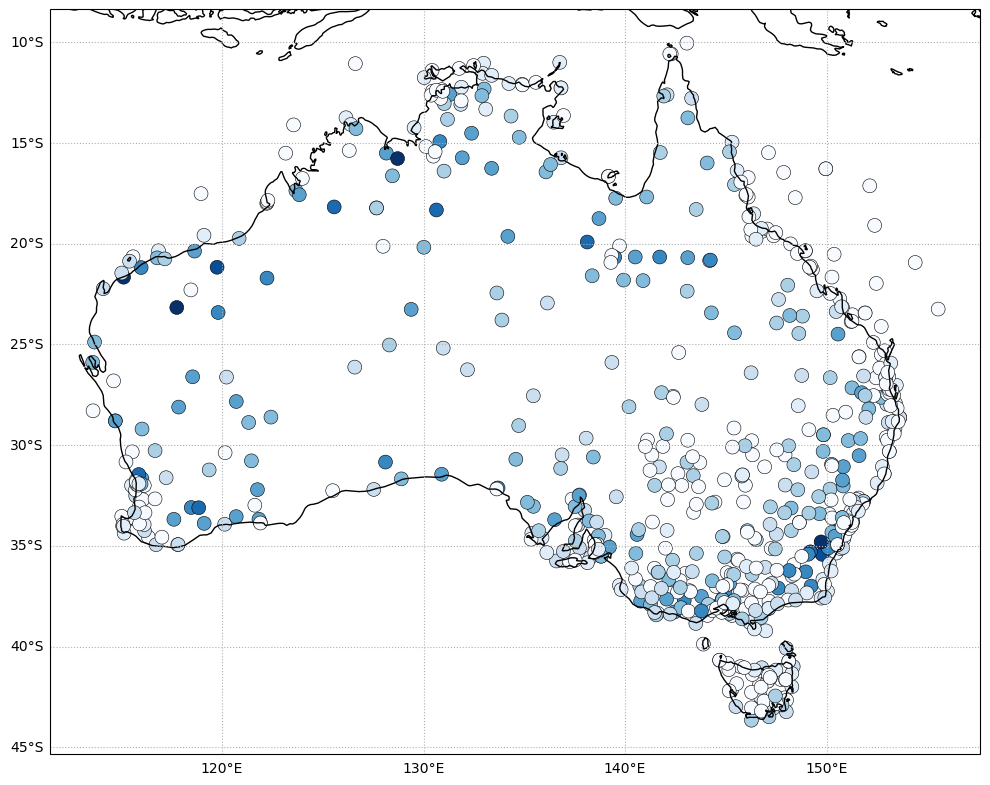

In [160]:
plt.figure(figsize=[12,10])
ax=plt.axes(projection=ccrs.PlateCarree())
obs_daily_count.plot.scatter(
   x="longitude",y="latitude",hue="__xarray_dataarray_variable__",ax=ax,levels=np.linspace(0,60,11),cmap="Blues",edgecolor="k",lw=0.4,add_colorbar=False,s=100)
ax.coastlines()
ax.gridlines(ls=":",draw_labels=["left","bottom"])
plt.title("")